In [22]:
import json
import os
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [23]:
SRC_DIRECTORY = r"C:\Users\vsornapudi\Documents\github\EDA\machine-reading-comprehension\src"

TRAINSET_PATH = os.path.join(SRC_DIRECTORY, 'data', "squad", 'train-v2.0.json')
DEVSET_PATH = os.path.join(SRC_DIRECTORY, 'data', "squad", 'dev-v2.0.json')

PROCESSED_TRAINSET_PATH = os.path.join(SRC_DIRECTORY, 'outputs', "squad", "processed_train_2017", 'squad_like_json.json')
PROCESSED_DEVSET_PATH = os.path.join(SRC_DIRECTORY, 'outputs', "squad", "processed_dev_2017", 'squad_like_json.json')

In [24]:
def squad_load(data_path):
    """
    Loads train/dev/test dataset json file.

    :param data_path: path to data file to read json from
    :return: list of documents in the dataset
    """
    with open(data_path, 'r') as f:
        docs = json.load(f)
    return docs

In [25]:
def print_1d_stats(vector_1d):
    print(f"Maximum of {np.max(vector_1d)} at index: {np.argmax(vector_1d)}")
    print(f"Mininmun of {np.min(vector_1d)} at index: {np.argmin(vector_1d)}")
    print(f"Mean is {np.mean(vector_1d)}")
    print(f"Variance is {np.var(vector_1d)}")
    print(f"Median is {np.median(vector_1d)}")


def generate_1d_graphs(vector, title):
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    sns.boxplot(data=vector, ax=axes[0])
    sns.histplot(vector, kde=True, bins=25, ax=axes[1])
    fig.suptitle(title)
    fig.tight_layout(pad=3.0)
    plt.show()

def flatten(l):
    return [item for sublist in l for item in sublist]

def first_2_words_piechart(strings):

    word1 = flatten([string[0:1] for string in strings])
    word2 = flatten([string[1:2] for string in strings])

    len_word1 = len(word1)
    len_word2 = len(word2)

    word1 = Counter(word1)
    word2 = Counter(word2)

    word1_values = [int(100* value / len_word1) for value in word1.values()]
    word2_values = [int(100* value / len_word2) for value in word2.values()]

    cleaned_word1_values = [value for value in word1_values if value > 1]
    cleaned_word2_values = [value for value in word2_values if value > 1]

    others_word1_values = sum([value for value in word1_values if value <= 1])
    others_word2_values = sum([value for value in word2_values if value <= 1])
    cleaned_word1_values.append(others_word1_values)
    cleaned_word2_values.append(others_word2_values)

    cleaned_word1_keys = [key for i, key in enumerate(word1.keys()) if word1_values[i] > 1]
    cleaned_word2_keys = [key for i, key in enumerate(word2.keys()) if word2_values[i] > 1]
    cleaned_word1_keys.append("'others'")
    cleaned_word2_keys.append("'others'")

    fig, ax = plt.subplots(figsize=(8,10))
    size = 0.4

    ax.pie(cleaned_word1_values, 
        radius=1,
        labels=cleaned_word1_keys,
        labeldistance = 0.7,
        wedgeprops=dict(width=size, edgecolor='w'),
        rotatelabels =True)

    ax.pie(cleaned_word2_values, 
        radius=1-size, 
        labels = cleaned_word2_keys,
        labeldistance = 0.5,
        wedgeprops=dict(width=size, edgecolor='w'),
        rotatelabels =True)

    ax.set(aspect="equal", title='First 2 words of questions')
    plt.show()

In [26]:
def stats_and_graphs(docs):

    print(f"Number of documents: {len(docs)}\n")

    qa_list = []
    for doc in docs:
        for para in doc['paragraphs']:
            for qas in para['qas']:
                qa_list.append(qas)
    questions = [qas['question'].strip() for qas in qa_list] #### strip is must####
    answers = [[answer['text'].strip() for answer in qas['answers']] for qas in qa_list if not qas['is_impossible']]

    # questions stats

    print("QUESTIONS -------->\n")
    print(f"Number of questions: {len(questions)}")
    print(f"Number of unique questions: {len(set(questions))}\n")

    questions_words = []
    for question in questions:
        questions_words.extend(question.split(" "))
    print(f"Number of distinct words in questions: {len(set(questions_words))}")

    questions_lengths = [len(question.split(" ")) for question in questions]
    print("\n|| Question length stats:")
    print_1d_stats(questions_lengths)
    generate_1d_graphs(questions_lengths, 'Question lengths')

    n_q_per_doc = {}
    for doc_id, doc in enumerate(docs):
        for i, para in enumerate(doc['paragraphs']):
            if i==0:
                n_q_per_doc[doc_id] = len(para['qas'])
            else:
                n_q_per_doc[doc_id] += len(para['qas'])
    n_q_per_doc = list(n_q_per_doc.values())
    print("\n|| # Questions per document stats:")
    print_1d_stats(n_q_per_doc)
    generate_1d_graphs(n_q_per_doc, '# Questions per document')

    n_answers = 0
    n_a_per_doc = {}
    for doc_id, doc in enumerate(docs):
        i=0
        for para in doc['paragraphs']:
            for qas in para['qas']:
                if not qas['is_impossible']:
                    if i==0:
                        n_a_per_doc[doc_id] = 1
                        n_answers += len(qas['answers'])
                        i += 1
                    else:
                        n_a_per_doc[doc_id] += 1
                        n_answers += len(qas['answers'])
    n_a_per_doc = list(n_a_per_doc.values())
    print(f"Number of answerable questions: {sum(n_a_per_doc)}")
    print(f"Number of answers: {n_answers}") 

    print("\n|| # Answerable questions per document stats:")
    print_1d_stats(n_a_per_doc)
    generate_1d_graphs(n_a_per_doc, '# Answerable questions per document')

    first_2q_words = []
    for question in questions:
        first_2q_words.append(question.split(" ")[:2])
    first_2_words_piechart(first_2q_words)
   
    # answer stats

    print("\nANSWERS -------->\n")
    answer_lengths = [np.mean([len(ans.split(" ")) for ans in answer]) for answer in answers]

    # n distinct words in answers
    answers_words = []
    for answer in answers:
        for ans in answer:
            answers_words.extend(ans.split(" "))
    print(f"Number of distinct words in answers: {len(set(answers_words))}")

    print("\n|| Answer length stats:")
    print_1d_stats(answer_lengths)
    generate_1d_graphs(answer_lengths, 'Answer lengths') 

    apq_list = []
    for doc in docs:
        for para in doc['paragraphs']:
            for qas in para['qas']:
                if not qas['is_impossible']:
                    apq_list.append(len(qas['answers']))
    print("\n|| # Answers per question stats:")
    print_1d_stats(apq_list)
    generate_1d_graphs(apq_list, '# Answers per question')


    # paragraph stats
    print("\nPARAGRAPHS -------->\n")

    paras = {}
    for doc_id, doc in enumerate(docs):
        paras[doc_id] = [para['context'] for para in doc['paragraphs']]
    para_list = flatten(paras.values())

    print(f"Number of paragraphs in dataset: {len(flatten(paras.values()))}")

    para_lengths = [len(para.split(" ")) for para in para_list]
    print("\n|| Paragraph length stats:")
    print_1d_stats(para_lengths)
    generate_1d_graphs(para_lengths, 'Paragraph lengths')

    para_counts = [len(para) for para in paras.values()]
    print("\n|| # Paragraphs per doc stats:")
    print_1d_stats(para_counts)
    generate_1d_graphs(para_counts, '# Paragraphs per doc')


# Original Train set

In [27]:
train_docs = squad_load(TRAINSET_PATH)['data']

In [28]:
pprint(train_docs[0])

{'paragraphs': [{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ '
                            'bee-YON-say) (born September 4, 1981) is an '
                            'American singer, songwriter, record producer and '
                            'actress. Born and raised in Houston, Texas, she '
                            'performed in various singing and dancing '
                            'competitions as a child, and rose to fame in the '
                            'late 1990s as lead singer of R&B girl-group '
                            "Destiny's Child. Managed by her father, Mathew "
                            "Knowles, the group became one of the world's "
                            'best-selling girl groups of all time. Their '
                            "hiatus saw the release of Beyoncé's debut album, "
                            'Dangerously in Love (2003), which established her '
                            'as a solo artist worldwide, earned five Gram

Number of documents: 442

QUESTIONS -------->

Number of questions: 130319
Number of unique questions: 130187

Number of distinct words in questions: 76475

|| Question length stats:
Maximum of 40 at index: 45706
Mininmun of 1 at index: 50678
Mean is 9.900689845686355
Variance is 11.725924293333074
Median is 9.0


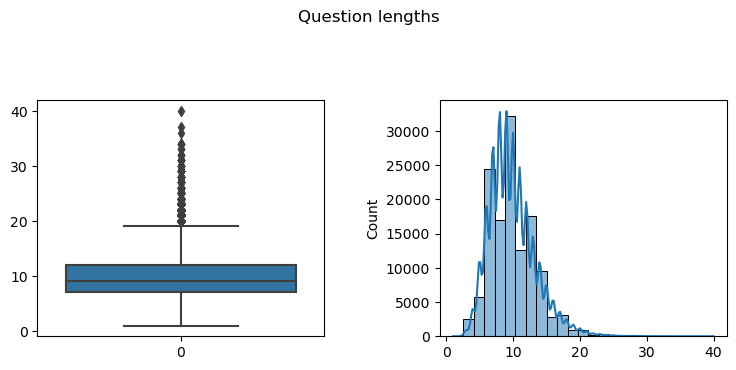


|| # Questions per document stats:
Maximum of 883 at index: 171
Mininmun of 36 at index: 105
Mean is 294.8393665158371
Variance is 11746.750214983313
Median is 279.0


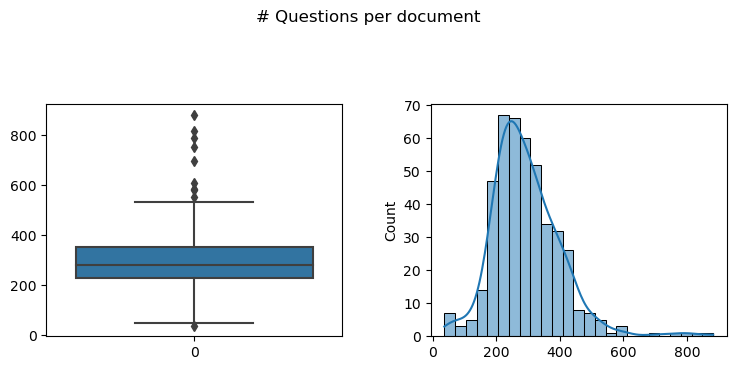

Number of answerable questions: 86821
Number of answers: 86821

|| # Answerable questions per document stats:
Maximum of 817 at index: 7
Mininmun of 36 at index: 105
Mean is 197.32045454545454
Variance is 13438.54958161157
Median is 167.5


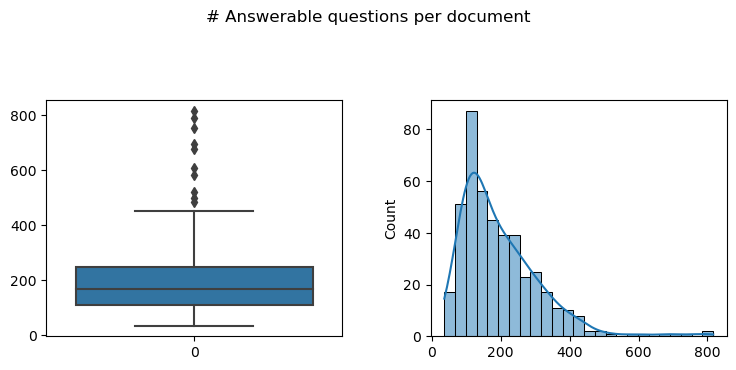

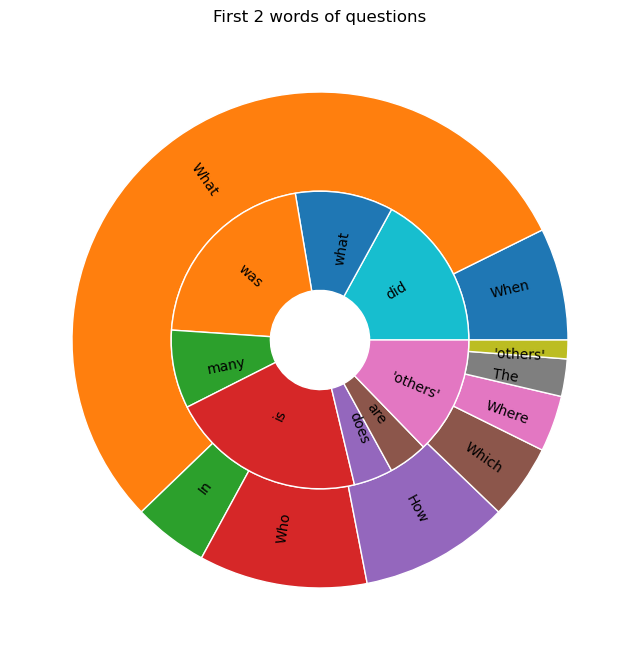


ANSWERS -------->

Number of distinct words in answers: 55391

|| Answer length stats:
Maximum of 43.0 at index: 2853
Mininmun of 1.0 at index: 2
Mean is 3.162794715564207
Variance is 11.499442064595149
Median is 2.0


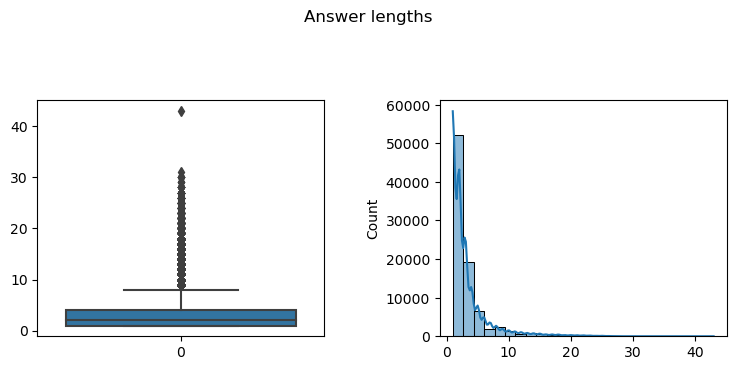


|| # Answers per question stats:
Maximum of 1 at index: 0
Mininmun of 1 at index: 0
Mean is 1.0
Variance is 0.0
Median is 1.0


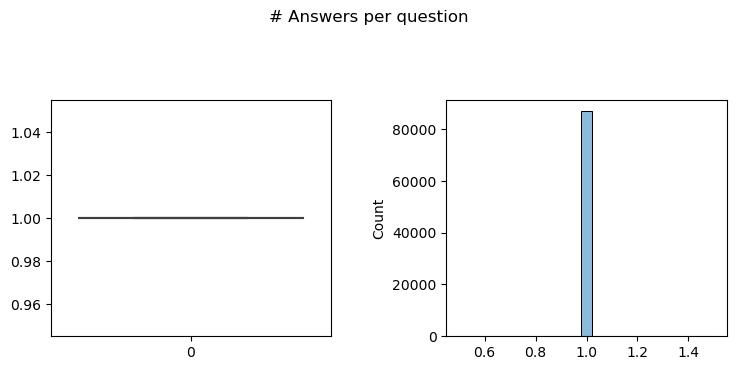


PARAGRAPHS -------->

Number of paragraphs in dataset: 19035

|| Paragraph length stats:
Maximum of 653 at index: 12251
Mininmun of 20 at index: 2199
Mean is 116.58744418177042
Variance is 2467.4075754746227
Median is 107.0


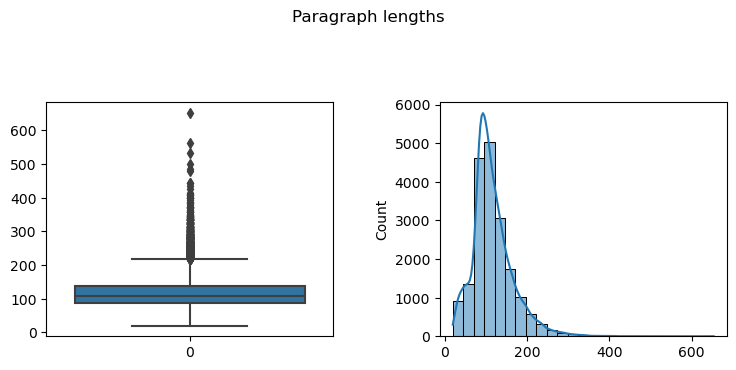


|| # Paragraphs per doc stats:
Maximum of 149 at index: 11
Mininmun of 10 at index: 105
Mean is 43.06561085972851
Variance is 459.71741467209915
Median is 37.0


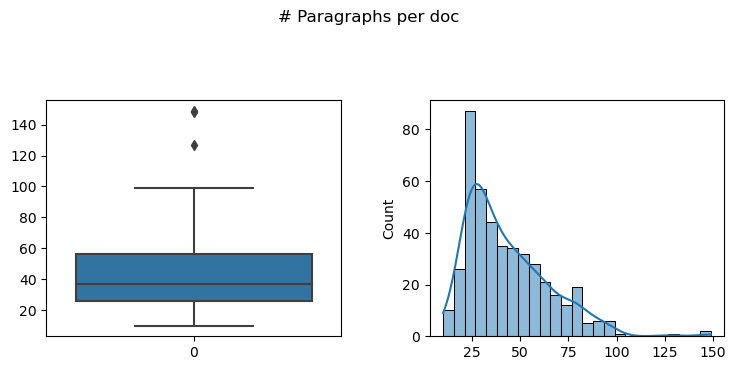

In [29]:
stats_and_graphs(train_docs)

# Original Dev set

Number of documents: 35

QUESTIONS -------->

Number of questions: 11873
Number of unique questions: 11860

Number of distinct words in questions: 14721

|| Question length stats:
Maximum of 31 at index: 3331
Mininmun of 3 at index: 2022
Mean is 10.025772761728291
Variance is 12.192547253003548
Median is 10.0


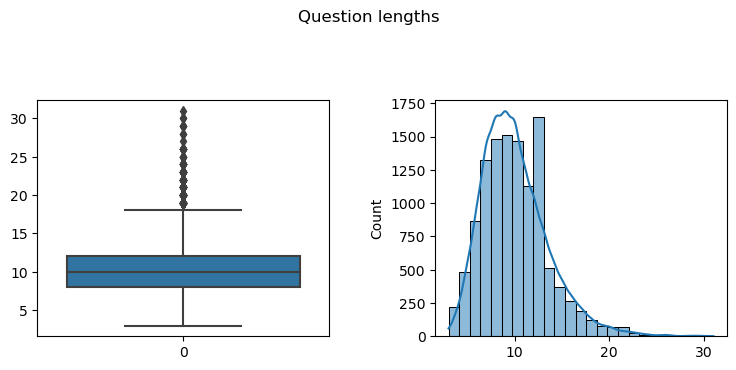


|| # Questions per document stats:
Maximum of 515 at index: 22
Mininmun of 192 at index: 21
Mean is 339.22857142857146
Variance is 8413.833469387755
Median is 356.0


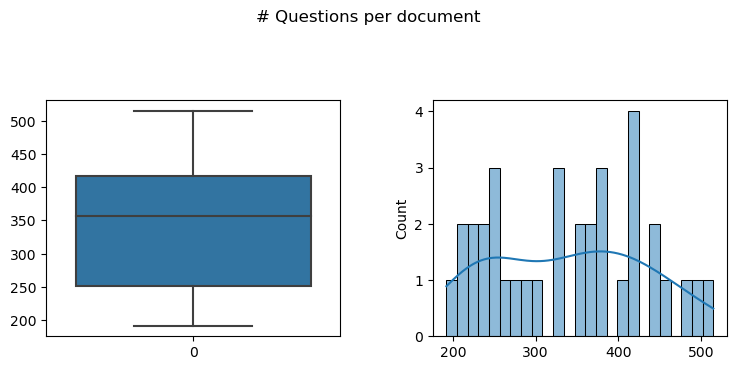

Number of answerable questions: 5928
Number of answers: 20302

|| # Answerable questions per document stats:
Maximum of 297 at index: 22
Mininmun of 96 at index: 0
Mean is 169.37142857142857
Variance is 3135.433469387755
Median is 176.0


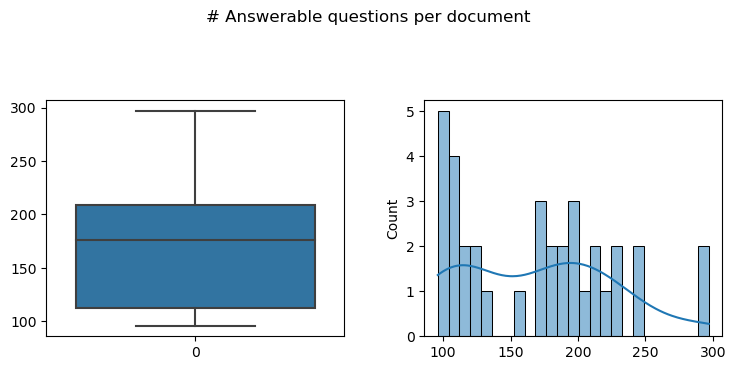

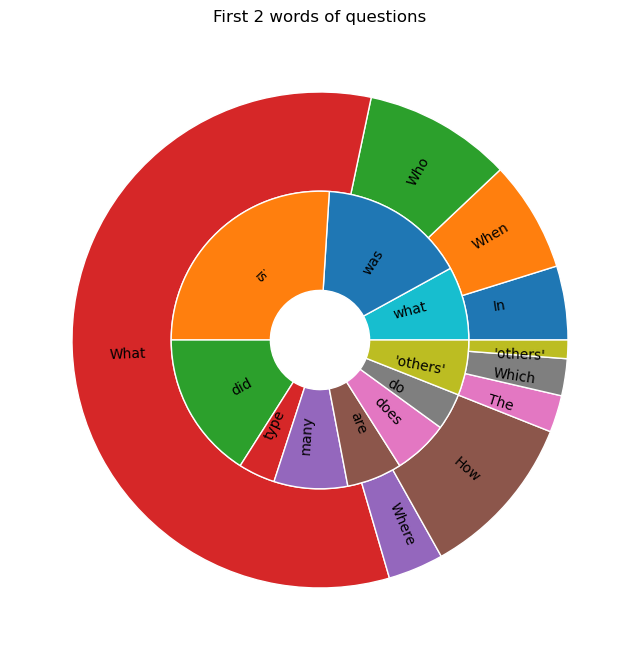


ANSWERS -------->

Number of distinct words in answers: 9204

|| Answer length stats:
Maximum of 22.333333333333332 at index: 1619
Mininmun of 1.0 at index: 0
Mean is 3.041784750337382
Variance is 6.843862259260625
Median is 2.0


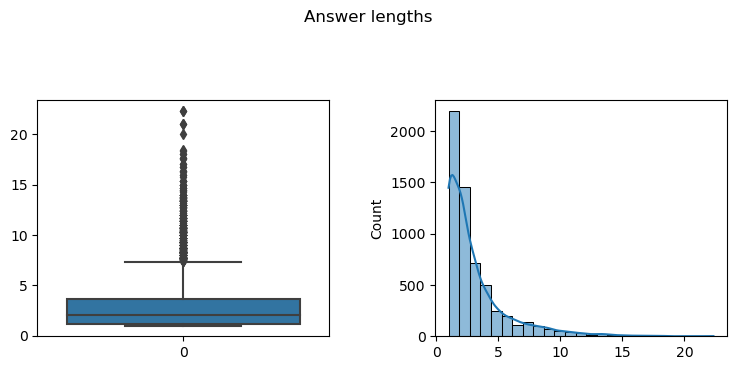


|| # Answers per question stats:
Maximum of 6 at index: 2804
Mininmun of 1 at index: 1242
Mean is 3.4247638326585697
Variance is 0.6252437026595347
Median is 3.0


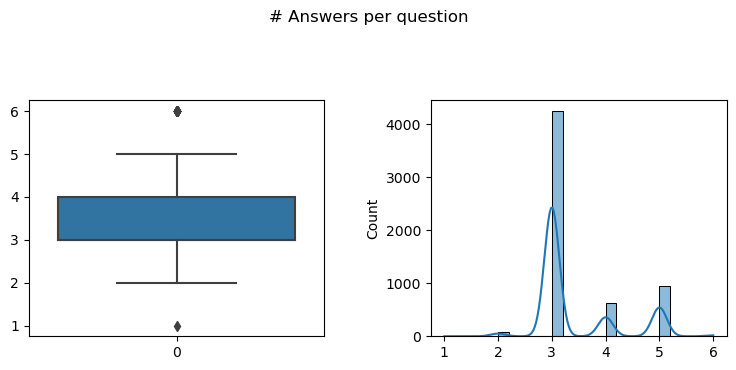


PARAGRAPHS -------->

Number of paragraphs in dataset: 1204

|| Paragraph length stats:
Maximum of 629 at index: 368
Mininmun of 25 at index: 115
Mean is 126.53654485049834
Variance is 3300.278564806128
Median is 113.0


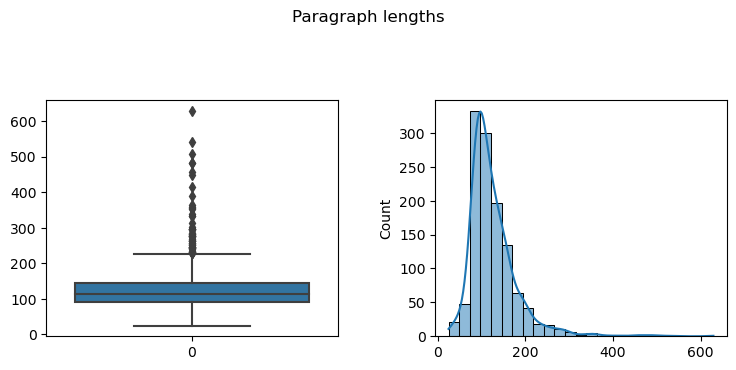


|| # Paragraphs per doc stats:
Maximum of 49 at index: 25
Mininmun of 21 at index: 10
Mean is 34.4
Variance is 92.58285714285714
Median is 37.0


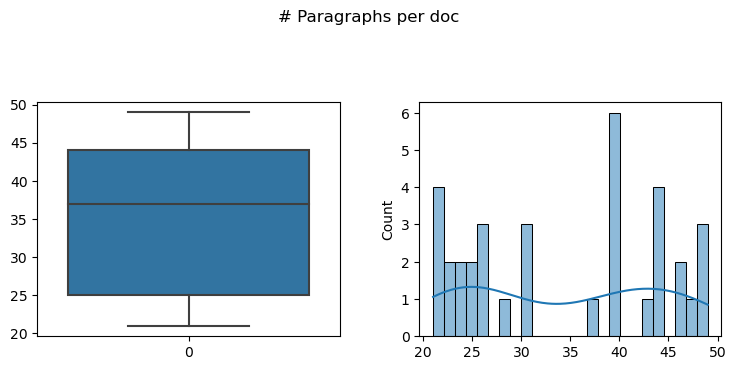

In [30]:
stats_and_graphs(squad_load(DEVSET_PATH)['data'])

# Processed Train set

Number of documents: 422

QUESTIONS -------->

Number of questions: 113639
Number of unique questions: 113525

Number of distinct words in questions: 70566

|| Question length stats:
Maximum of 40 at index: 39451
Mininmun of 1 at index: 43618
Mean is 9.872570156372372
Variance is 11.565340142331667
Median is 9.0


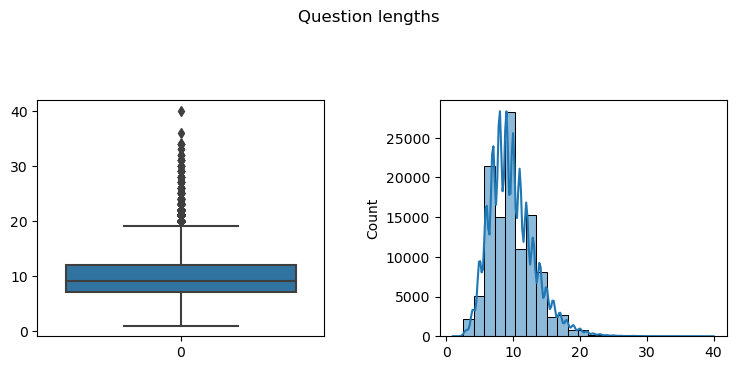


|| # Questions per document stats:
Maximum of 867 at index: 164
Mininmun of 36 at index: 102
Mean is 269.2867298578199
Variance is 10336.612098784844
Median is 253.0


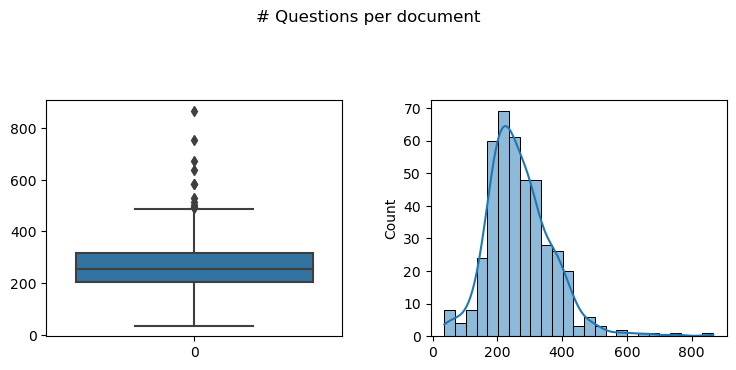

Number of answerable questions: 72124
Number of answers: 72124

|| # Answerable questions per document stats:
Maximum of 752 at index: 12
Mininmun of 21 at index: 38
Mean is 172.54545454545453
Variance is 11076.463244889082
Median is 143.5


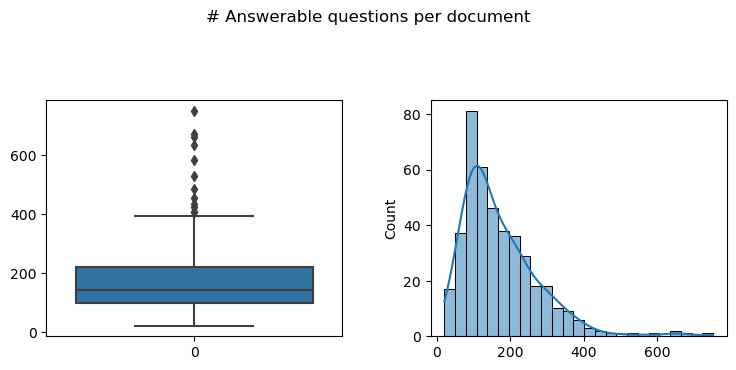

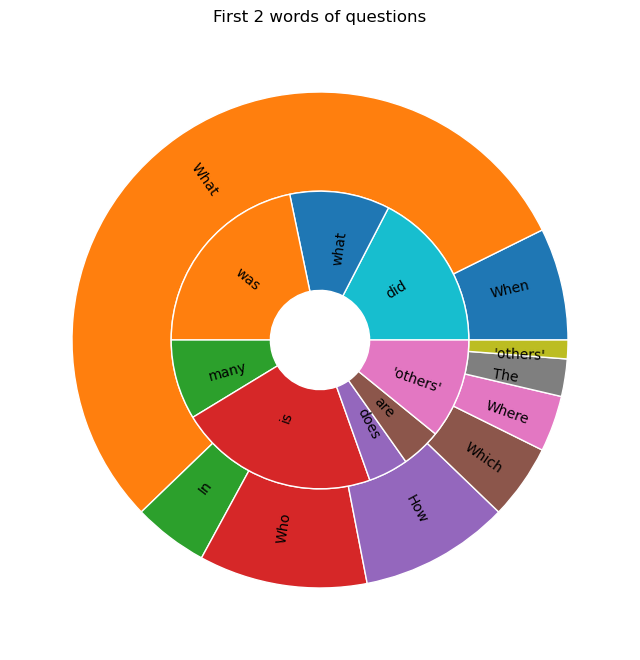


ANSWERS -------->

Number of distinct words in answers: 48211

|| Answer length stats:
Maximum of 43.0 at index: 2352
Mininmun of 1.0 at index: 2
Mean is 3.1227746658532527
Variance is 11.118765325465443
Median is 2.0


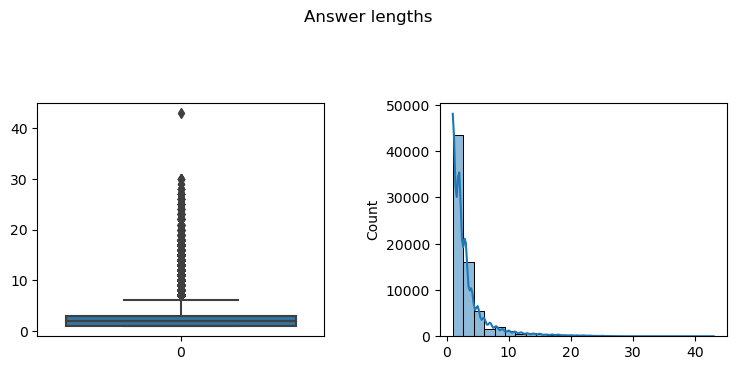


|| # Answers per question stats:
Maximum of 1 at index: 0
Mininmun of 1 at index: 0
Mean is 1.0
Variance is 0.0
Median is 1.0


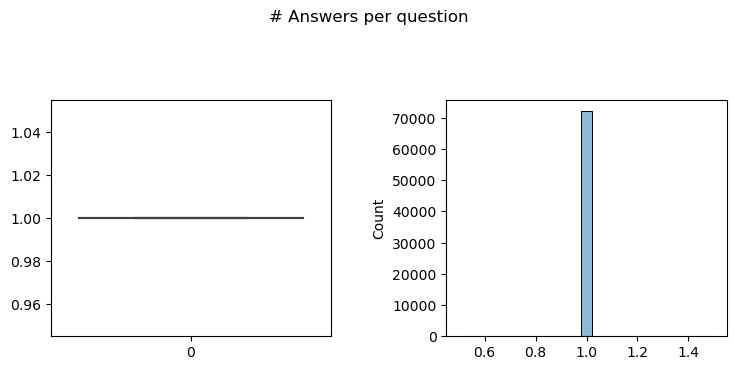


PARAGRAPHS -------->

Number of paragraphs in dataset: 17592

|| Paragraph length stats:
Maximum of 562 at index: 12447
Mininmun of 8 at index: 14326
Mean is 116.12130513869941
Variance is 2470.351019488064
Median is 107.0


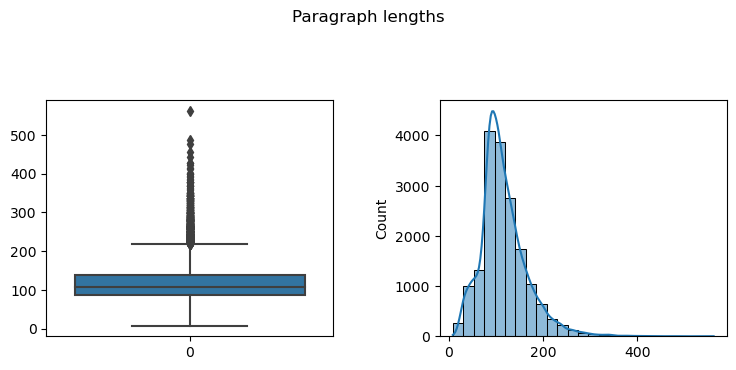


|| # Paragraphs per doc stats:
Maximum of 139 at index: 7
Mininmun of 1 at index: 163
Mean is 41.687203791469194
Variance is 410.2481300959098
Median is 36.0


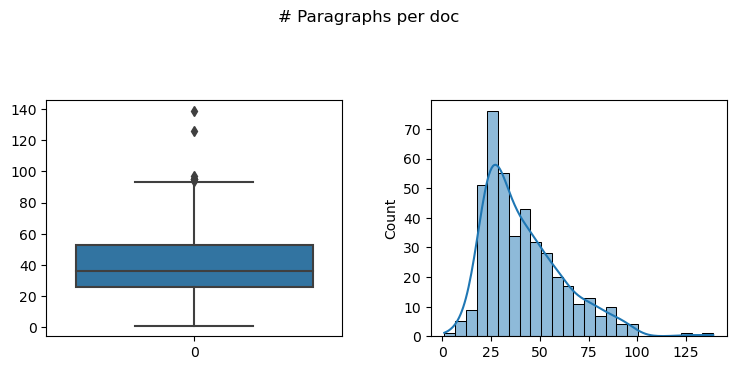

In [34]:
stats_and_graphs(squad_load(PROCESSED_TRAINSET_PATH))

# Processed Dev set

Number of documents: 32

QUESTIONS -------->

Number of questions: 10413
Number of unique questions: 10401

Number of distinct words in questions: 13734

|| Question length stats:
Maximum of 31 at index: 2496
Mininmun of 3 at index: 1417
Mean is 10.024776721405935
Variance is 12.44728777546118
Median is 10.0


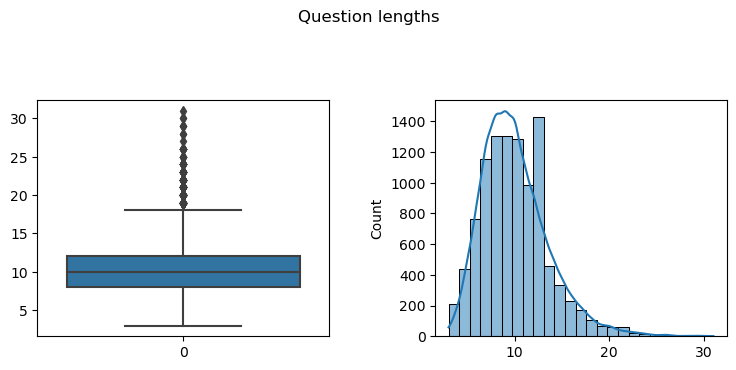


|| # Questions per document stats:
Maximum of 515 at index: 19
Mininmun of 127 at index: 17
Mean is 325.40625
Variance is 8091.6162109375
Median is 322.0


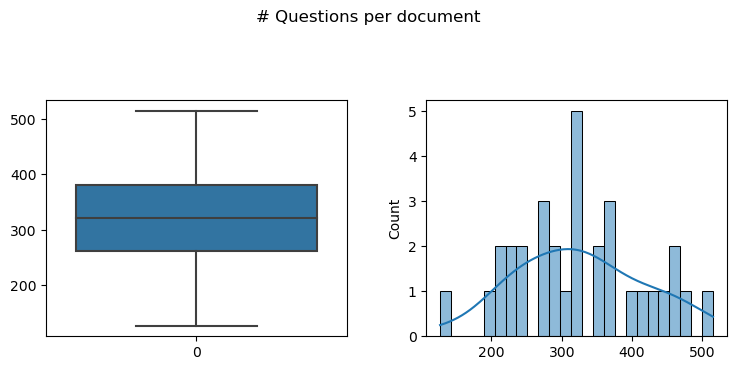

Number of answerable questions: 4789
Number of answers: 16281

|| # Answerable questions per document stats:
Maximum of 297 at index: 18
Mininmun of 84 at index: 17
Mean is 154.48387096774192
Variance is 2753.862643080124
Median is 145.0


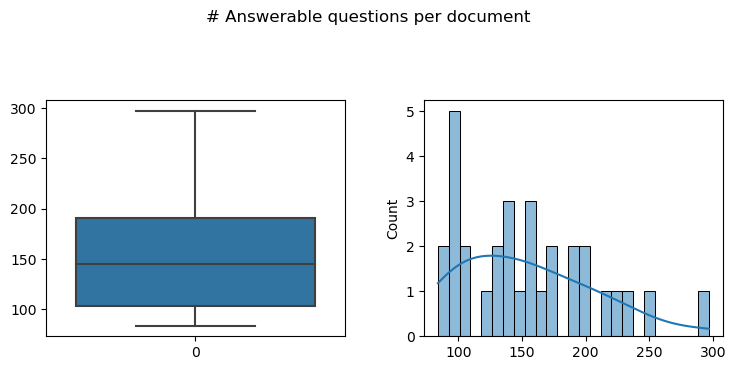

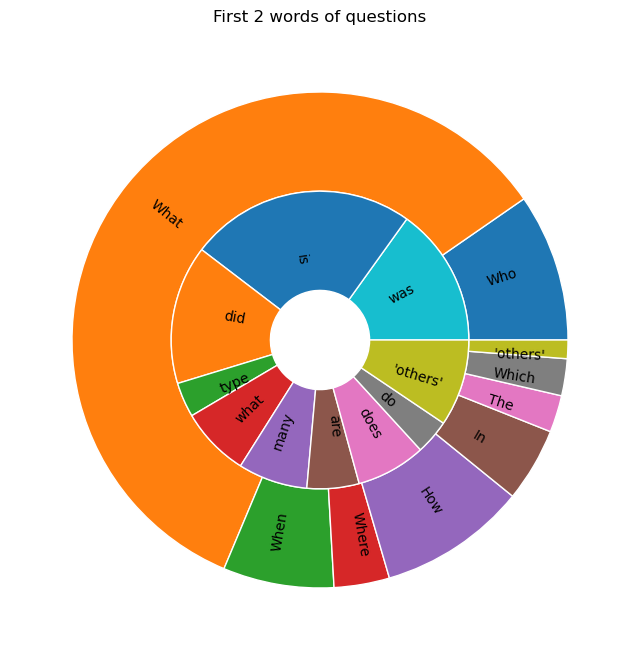


ANSWERS -------->

Number of distinct words in answers: 7905

|| Answer length stats:
Maximum of 22.333333333333332 at index: 1060
Mininmun of 1.0 at index: 1
Mean is 3.0742882995754157
Variance is 6.858640316781269
Median is 2.0


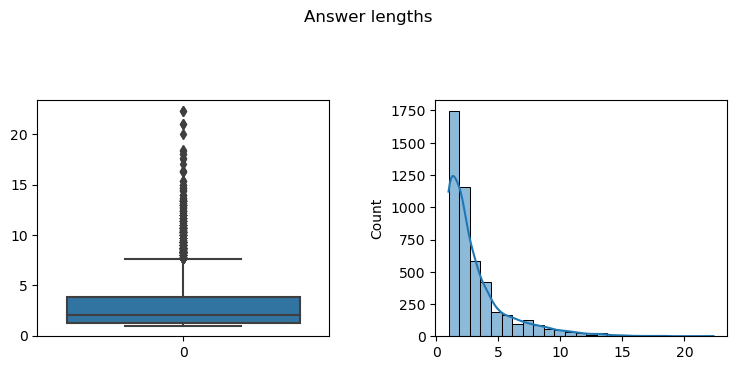


|| # Answers per question stats:
Maximum of 6 at index: 2116
Mininmun of 1 at index: 109
Mean is 3.399665901023178
Variance is 0.6976486668284897
Median is 3.0


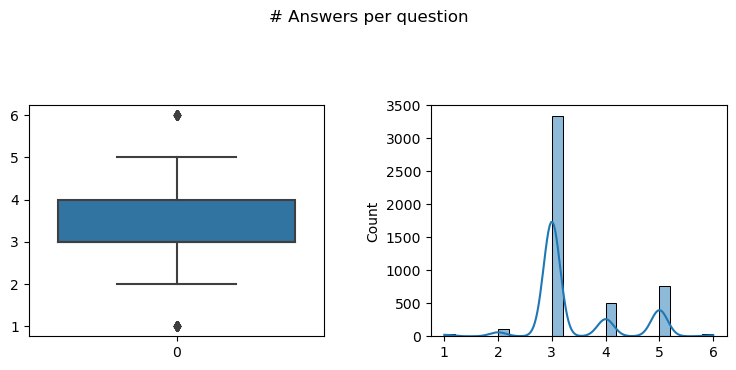


PARAGRAPHS -------->

Number of paragraphs in dataset: 1105

|| Paragraph length stats:
Maximum of 540 at index: 314
Mininmun of 13 at index: 243
Mean is 128.3294117647059
Variance is 3747.849858929997
Median is 113.0


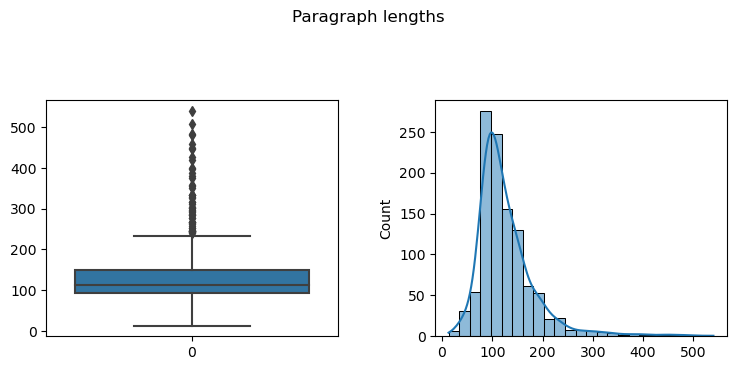


|| # Paragraphs per doc stats:
Maximum of 49 at index: 21
Mininmun of 6 at index: 17
Mean is 34.53125
Variance is 113.9990234375
Median is 35.5


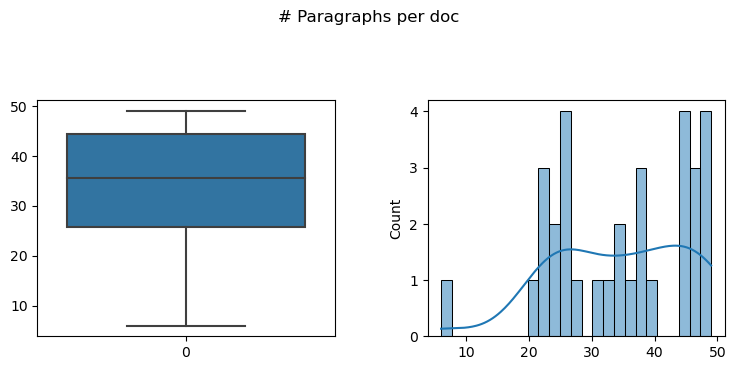

In [33]:
stats_and_graphs(squad_load(PROCESSED_DEVSET_PATH))